<a href="https://colab.research.google.com/github/mayuresh23sawant/NLP-based-stock-selection/blob/master/NLP_Stock_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Based Stock Selection Model

This project is based on the paper [Lazy Prices](https://ssrn.com/abstract=3254078
) by Lauren Cohen, Christopher Malloy, and Quoc Nguyen. 

In the paper, they show that when firms make an active change in their reporting practices, this conveys an important signal about future firm operations. Changes to the language and construction of financial reports also have strong implications for firms’ future returns: a portfolio that shorts “changers” and buys “non-changers” earns up to 188 basis points in monthly alphas (over 22% per year) in the future.

Here, I will only use the 10-K filings of Amazon Inc. to save computation but in the real world, this can be used for multiple stocks. 

## 1. Loading Packages

In [0]:
!pip install alphalens
!pip install nltk
!pip install six
!pip install tqdm
!pip install ratelimit
!pip install requests

In [0]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import matplotlib.pyplot as plt
import requests

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## 2. Data Collection

We'll be running NLP analysis on 10-k documents. To do that, we first need to download the documents from the U.S. Securities and Exchange Commission website.

In an attempt to level the playing field for all investors, the SEC maintains an online database called EDGAR (the Electronic Data Gathering, Analysis, and Retrieval system) online from which investors can access this and other information filed with the agency.EDGAR performs automated collection, validation, indexing, acceptance, and forwarding of submissions by companies and others who are required by law to file forms with the SEC.

As mentioned earlier, I just use the stock of Amazon but multiple stocks can be added to the dictionary keeping rest of the notebook intact. 

In [0]:
cik_lookup = {'AMZN': '0001018724'}

In [0]:
from ratelimit import limits, sleep_and_retry

class SecAPI(object):
    SEC_CALL_LIMIT = {'calls': 10, 'seconds': 1}

    @staticmethod
    @sleep_and_retry
    # Dividing the call limit by half to avoid coming close to the limit
    @limits(calls=SEC_CALL_LIMIT['calls'] / 2, period=SEC_CALL_LIMIT['seconds'])
    def _call_sec(url):
        return requests.get(url)

    def get(self, url):
        return self._call_sec(url).text

In [0]:
sec_api = SecAPI()

In [0]:
from bs4 import BeautifulSoup

def get_sec_data(cik, doc_type, start=0, count=60):
    newest_pricing_data = pd.to_datetime('2020-06-01')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]

    return entries

In [8]:
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data['AMZN'][:5])

[('https://www.sec.gov/Archives/edgar/data/1018724/000101872420000004/0001018724-20-000004-index.htm',
  '10-K',
  '2020-01-31'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872419000004/0001018724-19-000004-index.htm',
  '10-K',
  '2019-02-01'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872418000005/0001018724-18-000005-index.htm',
  '10-K',
  '2018-02-02'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872416000172/0001018724-16-000172-index.htm',
  '10-K',
  '2016-01-29')]


As it can be seen, these are the links for the first 5 docs retrived from the SEC for Amazon

In [0]:
raw_fillings_by_ticker = {}
for ticker, data in sec_data.items():
  raw_fillings_by_ticker[ticker] = {}
  for index_url, file_type, file_date in data:
    if(file_type == '10-K'):
      file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
      raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)

In [10]:
print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker['AMZN'].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001018724-20-000004.txt : 20200131
<SEC-HEADER>0001018724-20-000004.hdr.sgml : 20200131
<ACCEPTANCE-DATETIME>20200130204613
ACCESSION NUMBER:		0001018724-20-000004
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		109
CONFORMED PERIOD OF REPORT:	20191231
FILED AS OF DATE:		20200131
DATE AS OF CHANGE:		20200130

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		20562951

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<

In [0]:
import re

def get_documents(text):
    """
    Extract the documents from the text

    Parameters --> text : str (The text with the document strings inside)

    Returns --> extracted_docs : list of str (The document strings found in `text`)
    """
    
    filings_list = []
    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    
    doc_start_is = [x.end() for x in doc_start_pattern.finditer(text)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(text)]
    
    for doc_start_i, doc_end_i in zip(doc_start_is, doc_end_is): 
        filings_list.append(text[doc_start_i : doc_end_i])
    
    return filings_list

In [0]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in raw_fillings.items():
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)

In [13]:
print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker['AMZN'].items()
    for doc_i, doc in enumerate(docs)][:3]))

Document 0 Filed on 2020-01-31:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20191231x10k.htm
<DESCRIPTION>10-K
<TEXT>
<XBRL>
<?xml version="1.0" encoding="UTF-8"?>
<!--XBRL Document Created with Wdesk from Workiva-->
<!--p:c57a17684e854b...

Document 1 Filed on 2020-01-31:

<TYPE>EX-4.6
<SEQUENCE>2
<FILENAME>amzn-20191231xex46.htm
<DESCRIPTION>EXHIBIT 4.6
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>...

Document 2 Filed on 2020-01-31:

<TYPE>EX-21.1
<SEQUENCE>3
<FILENAME>amzn-20191231xex211.htm
<DESCRIPTION>EXHIBIT 21.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<ht...


In [0]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters --> doc : str (The document string)

    Returns --> doc_type : str (The document type lowercased)
    """
    
    regex = re.compile(r'<TYPE>.+')
    matches = regex.findall(doc)
    doc_type_list = [match [ len('<TYPE>'): ] for match in matches]
    doc_type_str = ' '.join(doc_type_list).lower()
  
    return doc_type_str

In [0]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})

In [0]:
def print_ten_k_data(ten_k_data, fields, field_length_limit=50):
    indentation = '  '

    print('[')
    for ten_k in ten_k_data:
        print_statement = '{}{{'.format(indentation)
        for field in fields:
            value = str(ten_k[field])

            # Show return lines in output
            if isinstance(value, str):
                value_str = '\'{}\''.format(value.replace('\n', '\\n'))
            else:
                value_str = str(value)

            # Cut off the string if it gets too long
            if len(value_str) > field_length_limit:
                value_str = value_str[:field_length_limit] + '...'

            print_statement += '\n{}{}: {}'.format(indentation * 2, field, value_str)

        print_statement += '},'
        print(print_statement)
    print(']')

In [17]:
print_ten_k_data(ten_ks_by_ticker['AMZN'][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2019123...
    file_date: '2020-01-31'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2018123...
    file_date: '2019-02-01'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2017123...
    file_date: '2018-02-02'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2016123...
    file_date: '2017-02-10'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2015123...
    file_date: '2016-01-29'},
]


## 3. Pre Processing

### Cleanup
We'll clean up the data by removing all the tags and converting the remaining text to lowercase. 

In [0]:
def remove_html_tags(text):
    return (BeautifulSoup(text, 'html.parser').get_text())

def clean_text(text):
    return (remove_html_tags(text).lower())

In [0]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in ten_ks:
        ten_k['file_clean'] = clean_text(ten_k['file'])

In [20]:
ten_k.keys()

dict_keys(['cik', 'file', 'file_date', 'file_clean'])

### Lemmatize
Lemmatization aims to remove inflectional endings only, and return the base or dictionary form of a word, which is known as lemma.

In [0]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters --> words : list of str (List of words)

    Returns --> lemmatized_words : list of str (List of lemmatized words)
    """

    wnl = WordNetLemmatizer()
    # lemmatize verbs
    lemmatized_words = [wnl.lemmatize(w, 'v') for w in words]
    
    return lemmatized_words

In [0]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in ten_ks:
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))

In [23]:
print_ten_k_data(ten_ks_by_ticker['AMZN'][:5], ['file_lemma'])

[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20191231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20181231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20171231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20151231x10k', 'htm', '...},
]


### Removing Stopwords

In [0]:
from nltk.corpus import stopwords

lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in ten_ks:
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]

In [25]:
print_ten_k_data(ten_ks_by_ticker['AMZN'][:5], ['file_lemma'])

[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20191231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20181231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20171231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20151231x10k', 'htm', '...},
]


## 4. Sentiment Analysis

We'll use the [Loughran-McDonald Sentiment Word Lists](https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists). 

It is an Excel file containing each of the LM sentiment words by category (Negative, Positive, Uncertainty, Litigious, Strong Modal, Weak Modal, Constraining). It was specifically made for financial analysis. 

In [26]:
sentiment_df=pd.read_csv('/content/loughran_mcdonald_master_dic_2016.csv')
sentiment_df.head()

,Word,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
0,AARDVARK,1,275,1.603442e-08,1.306189e-08,3.665256e-06,82,0,0,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.749209e-10,1.028197e-11,1.014208e-08,1,0,0,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,8,4.664558e-10,1.465871e-10,6.401309e-08,7,0,0,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,6,3.498419e-10,1.758203e-10,7.213526e-08,6,0,0,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,6729,3.923477e-07,3.752169e-07,3.452425e-05,845,0,0,0,0,0,0,0,0,0,0,3,12of12inf


In [27]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


### Bag of Words
using the sentiment word lists, let's generate sentiment bag of words from the 10-k documents.

In [0]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters --> sentiment_words: Pandas Series (Words that signify a certain sentiment)
                   docs : list of str (List of documents used to generate bag of words)

    Returns --> bag_of_words : 2-d Numpy Ndarray of int
                Bag of words sentiment for each document
                The first dimension is the document.
                The second dimension is the word.
    """
    
    vectorizer = CountVectorizer(vocabulary=sentiment_words.values)
    
    # build bad of words matrix
    word_matrix = vectorizer.fit_transform(docs)
    
    return word_matrix.toarray()

In [0]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

In [30]:
print_ten_k_data([sentiment_bow_ten_ks['AMZN']], sentiments)

[
  {
    negative: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    positive: '[[12  0  0 ...  0  0  0]\n [15  0  0 ...  0  0  0...
    uncertainty: '[[0 0 0 ... 1 1 2]\n [0 0 0 ... 1 1 2]\n [0 0 0 ....
    litigious: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    constraining: '[[0 0 0 ... 0 0 2]\n [0 0 0 ... 0 0 2]\n [0 0 0 ....
    interesting: '[[2 0 0 ... 0 0 0]\n [2 0 0 ... 0 0 0]\n [2 0 0 ....},
]


### Jaccard Similarity Score
Using the bag of words, let's calculate the jaccard similarity on the bag of words and plot it over time. 

The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. It's a measure of similarity for the two sets of data, with a range from 0% to 100%.

In [0]:
from sklearn.metrics import jaccard_similarity_score


def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters --> bag_of_words : 2-d Numpy Ndarray of int
                    Bag of words sentiment for each document
                    The first dimension is the document.
                    The second dimension is the word.

    Returns --> jaccard_similarities : list of float (Jaccard similarities for neighboring documents)
    """
    
    jaccard_similarities = []
    bool_bow_mat = bag_of_words_matrix.astype(bool)
    
    # compute jaccard similary for neighboring docs
    for i in range(bag_of_words_matrix.shape[0]-1):
        jaccard_similarities.append(jaccard_similarity_score(bool_bow_mat[i], bool_bow_mat[i+1]))
    
    return jaccard_similarities

In [32]:
# Get dates for the universe
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [0]:
def plot_similarities(similarities_list, dates, title, labels):
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(20, 8))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates, similarities, label=label)
        plt.legend(loc=3, prop={'size': 25})
        plt.xticks(rotation=90)

    plt.show()

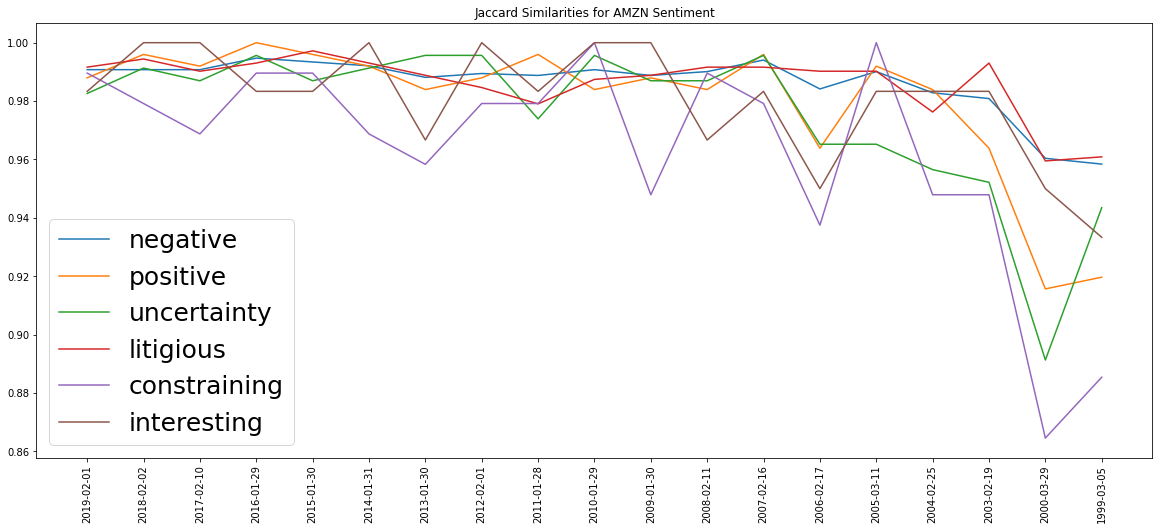

In [52]:
plot_similarities(
    [jaccard_similarities['AMZN'][sentiment] for sentiment in sentiments],
    file_dates['AMZN'][1:],
    'Jaccard Similarities for {} Sentiment'.format('AMZN'),
    sentiments)

### TFIDF
Using the sentiment word lists, let's generate sentiment TFIDF from the 10-k documents.

TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters --> sentiment_words: Pandas Series (Words that signify a certain sentiment)
                   docs : list of str (List of documents used to generate bag of words)

    Returns -->  tfidf : 2-d Numpy Ndarray of float
                  TFIDF sentiment for each document
                  The first dimension is the document.
                  The second dimension is the word.
    """
  
    # filter out words not in sentiment_words
    vectorizer = TfidfVectorizer(vocabulary=sentiment_words.values)
    
    # build tfidf matrix
    tfidf = vectorizer.fit_transform(docs)
    
    return tfidf.toarray()

In [0]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

In [55]:
print_ten_k_data([sentiment_tfidf_ten_ks['AMZN']], sentiments)

[
  {
    negative: '[[0.         0.         0.         ... 0.        ...
    positive: '[[0.19672975 0.         0.         ... 0.        ...
    uncertainty: '[[0.         0.         0.         ... 0.00570501...
    litigious: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    constraining: '[[0.         0.         0.         ... 0.        ...
    interesting: '[[0.01889287 0.         0.         ... 0.        ...},
]


### Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time.

Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.


In [0]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters --> tfidf : 2-d Numpy Ndarray of float
                    TFIDF sentiment for each document
                    The first dimension is the document.
                    The second dimension is the word.

    Returns --> cosine_similarities : list of float (Cosine similarities for neighboring documents)
    """
    cosine_similarities = list(np.diag(cosine_similarity(tfidf_matrix, tfidf_matrix), k=1))
    
    return cosine_similarities

In [0]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}

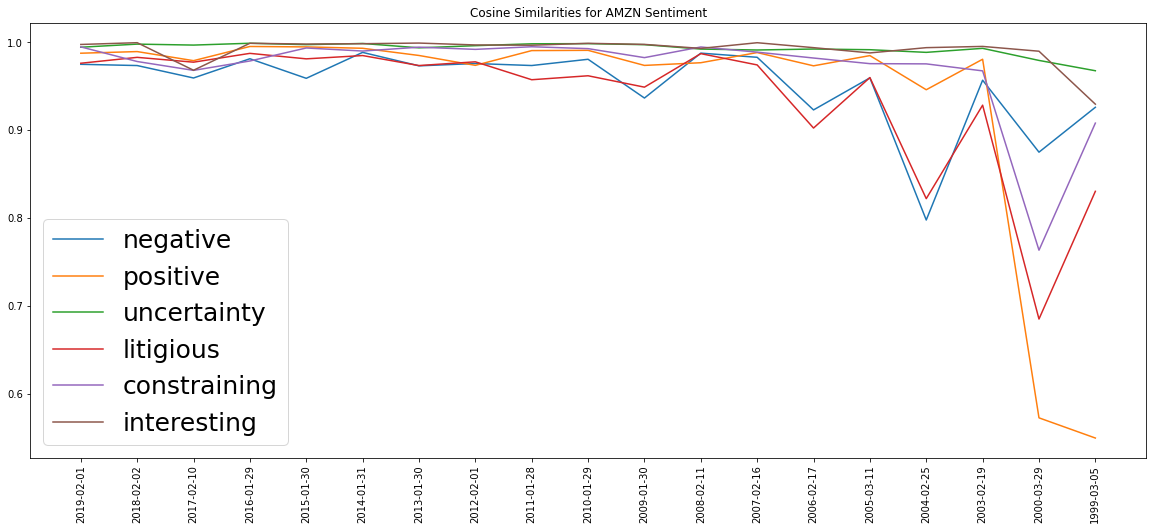

In [58]:
plot_similarities(
    [cosine_similarities['AMZN'][sentiment] for sentiment in sentiments],
    file_dates['AMZN'][1:],
    'Cosine Similarities for {} Sentiment'.format('AMZN'),
    sentiments)

## 5. Use Cosine Similarity as Alpha Factor
Alpha is a measure of the active return on an investment, the performance of that investment compared with a suitable market index. 

An alpha of 1% means the investment's return on investment over a selected period of time was 1% better than the market during that same period; a negative alpha means the investment underperformed the market.

### Price Data
Now we’ll evaluate the alpha factors by comparing them against the yearly pricing for stocks. We can download the pricing data from QuoteMedia.

In [111]:
pricing = pd.read_csv('/content/yr-quotemedia.csv', parse_dates=['date'])
pricing = pricing.pivot(index='date', columns='ticker', values='adj_close')


pricing.tail()

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,AAPC,AAPL,AAT,AAU,AAV,AAVL,AAWW,AAXJ,AAXN,AA_P_B,AA_W,AB,ABAC,ABAX,ABB,ABBV,ABC,ABCB,ABCD,ABCO,ABCW,ABDC,ABE,ABEO,ABEOW,ABEV,...,ZIONW,ZIONZ,ZIOP,ZIV,ZIXI,ZJZZT,ZKIN,ZLAB,ZLRG,ZLTQ,ZMH,ZMLP,ZN,ZNGA,ZNH,ZOES,ZOM,ZOOM,ZPIN,ZQK,ZROZ,ZS,ZSAN,ZSL,ZSML,ZSPH,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,39.432387,NaN,NaN,50.51,30.92,36.888991,32.90505,51.899708,310.12,3.947783,30.220552,11.22,21.752898,158.303858,NaN,103.664312,36.367967,0.9400,4.79,54.00,49.30,56.987290,26.48,50.45,NaN,19.155549,6.9200,54.875757,19.716305,57.743669,85.386716,24.936130,1.66,48.980,34.44,8.519642,NaN,3.45,NaN,5.538851,...,4.05,3.20,5.07,41.77,3.60,7100.00,NaN,NaN,NaN,27.91,113.42,25.478754,1.37,2.66,22.534243,29.91,NaN,0.32,15.18,2.210,112.148198,NaN,NaN,59.695,NaN,41.57,NaN,9.447271,41.934134,23.4,38.630,NaN,NaN,NaN,1.4300,NaN,NaN,NaN,100.0,0.50
2015-01-01,40.798626,NaN,31.27,33.26,19.06,38.069216,30.53000,41.338933,17.16,4.912700,22.203380,17.16,22.763348,149.815380,10.11,100.535790,35.887473,0.6780,5.08,9.52,41.34,51.110528,17.29,33.31,NaN,18.948743,3.6008,54.203667,16.528137,54.012469,99.376933,33.290209,4.85,49.610,43.52,8.794340,10.614846,3.36,1.2001,4.132171,...,3.39,2.21,8.31,41.31,5.08,11.00,NaN,NaN,22.955792,28.53,113.56,14.068041,1.86,2.68,36.192351,27.98,NaN,NaN,15.32,0.455,102.970327,NaN,45.60,64.550,21.7500,89.98,NaN,8.959081,47.036619,17.4,15.120,NaN,NaN,NaN,0.7900,14.1,NaN,10.07,100.0,1.00
2016-01-01,44.939092,28.08,26.76,38.67,7.24,39.819593,NaN,46.089912,53.50,4.053202,31.846957,23.44,32.656992,168.596157,9.84,113.083528,41.334093,0.9688,6.75,4.14,52.15,53.508889,24.24,30.90,21.44,20.244467,3.6177,51.908785,19.641728,59.347748,76.191885,43.070709,4.99,33.250,47.86,10.134808,11.090456,4.85,3.3200,4.717285,...,11.75,8.65,5.35,46.54,4.94,10.12,NaN,NaN,27.170000,43.52,NaN,16.679425,1.37,2.57,24.892730,23.99,NaN,NaN,15.11,NaN,105.079139,NaN,15.60,38.760,26.5877,NaN,11.910975,9.763192,52.982185,NaN,21.850,NaN,100.01,14.26,1.1989,8.0,NaN,15.59,100.0,25.00
2017-01-01,66.653918,53.87,81.62,69.85,9.00,58.835707,NaN,51.803585,81.60,3.378882,39.797356,37.82,36.522919,99.593649,10.60,167.901180,37.654925,1.0300,4.30,NaN,58.65,75.858764,26.50,NaN,NaN,23.647773,2.9500,49.294281,25.861168,95.032866,91.062109,48.019353,5.68,53.825,NaN,7.952247,14.540000,15.85,11.6000,6.383574,...,18.80,14.75,4.14,88.65,4.38,13.75,9.80,21.23,27.620000,56.48,NaN,15.550614,2.16,4.00,51.071082,16.72,1.9771,NaN,18.20,NaN,120.593382,NaN,10.40,31.400,26.9000,NaN,15.641173,12.643875,71.815333,NaN,20.825,NaN,100.10,NaN,1.2165,NaN,7.5931,12.52,25.0,0.01
2018-01-01,61.800000,46.88,81.63,73.35,9.81,52.880000,NaN,37.990000,67.90,2.575000,43.740000,46.00,35.250000,135.860000,NaN,185.400000,38.860000,0.7100,3.10,NaN,71.45,70.250000,64.98,NaN,NaN,28.750000,2.5537,83.250000,21.480000,94.480000,87.200000,53.100000,12.03,NaN,NaN,6.530000,14.695000,16.20,11.1600,4.720000,...,20.00,16.24,3.11,72.86,5.50,12.20,4.04,23.32,NaN,NaN,NaN,14.812000,3.95,4.13,36.550000,10.16,2.2100,NaN,NaN,NaN,115.750000,36.67,4.68,34.910,NaN,NaN,19.450000,11.450000,86.150000,NaN,24.300,26.74,NaN,NaN,1.3800,NaN,15.3400,9.17,NaN,NaN


In [112]:
cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}


for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values):
            cosine_similarities_df_dict['ticker'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])

cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
cosine_similarities_df['date'] = pd.DatetimeIndex(cosine_similarities_df['date']).year
cosine_similarities_df['date'] = pd.to_datetime(cosine_similarities_df['date'], format='%Y')


cosine_similarities_df.head()

,date,ticker,sentiment,value
0,2019-01-01,AMZN,negative,0.974958
1,2018-01-01,AMZN,negative,0.973553
2,2017-01-01,AMZN,negative,0.959390
3,2016-01-01,AMZN,negative,0.981287
4,2015-01-01,AMZN,negative,0.959012


In [0]:
import alphalens as al


factor_data = {}
skipped_sentiments = []

for sentiment in sentiments:
    cs_df = cosine_similarities_df[(cosine_similarities_df['sentiment'] == sentiment)]
    cs_df = cs_df.pivot(index='date', columns='ticker', values='value')

    try:
        data = al.utils.get_clean_factor_and_forward_returns(cs_df.stack(), pricing, quantiles=5, bins=None, periods=[1])
        factor_data[sentiment] = data
    except Exception as e:
      print(e)
      skipped_sentiments.append(sentiment)

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))
factor_data[sentiments[0]].head()

### Alphalens Format with Unix Time
Alphalen's factor_rank_autocorrelation and mean_return_by_quantile functions require unix timestamps to work, so we'll also create factor dataframes with unix time.

In [0]:
unixt_factor_data = {
    factor: data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in data.index.values],
        names=['date', 'asset']))
    for factor, data in factor_data.items()}

### Factor Returns
The factor return refers to the return on investment contributed by one particular factor. Here we'' calculate the returns based on the sentiments. 

Let's view the factor returns over time. We should be seeing it generally move up and to the right.

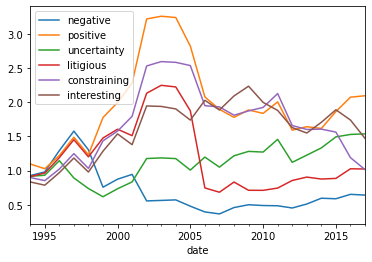

In [0]:
ls_factor_returns = pd.DataFrame()

for factor_name, data in factor_data.items():
    ls_factor_returns[factor_name] = al.performance.factor_returns(data).iloc[:, 0]

(1 + ls_factor_returns).cumprod().plot()

As expected, 10-k reports expressing positive sentiment produced the most gains while 10-k reports containing negative sentiment resulted in the most losses.


### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc87ef27e10>,
      dtype=object)

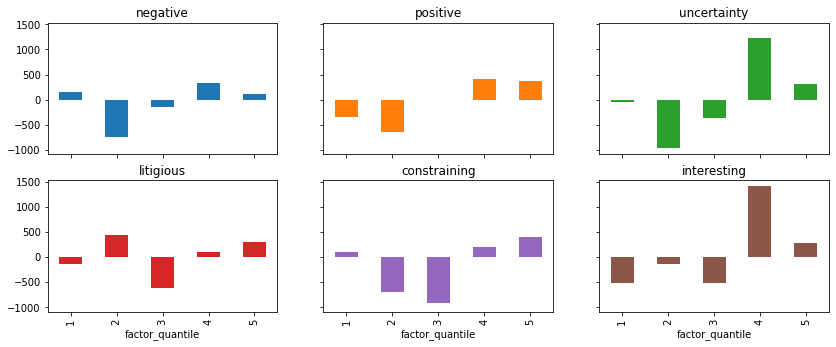

In [0]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unixt_factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False)

### Turnover Analysis
Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the Factor Rank Autocorrelation (FRA)

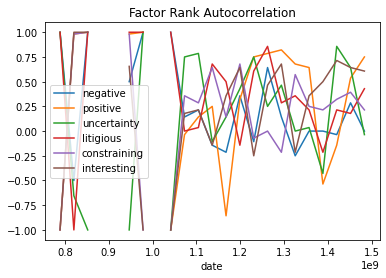

In [0]:
ls_FRA = pd.DataFrame()

for factor, data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

### Sharpe Ratio of the Alphas
The last analysis we'll do on the factors will be sharpe ratio. Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [0]:
daily_annualization_factor = np.sqrt(252)

(daily_annualization_factor * ls_factor_returns.mean() / ls_factor_returns.std()).round(2)

negative       -0.03
positive        4.12
uncertainty     2.98
litigious       1.96
constraining    1.29
interesting     2.72
dtype: float64